In [21]:
import glob
import logging
import os
import re
import warnings
from typing import List
from typing import Union

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame
import numpy as np

In [22]:
DEBUGGING: bool = False

if DEBUGGING:
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s',
                        level=logging.DEBUG)
    warnings.filterwarnings("default")
else:
    logging.disable(logging.CRITICAL)
    warnings.filterwarnings("ignore")

In [23]:
plot_sat_name: str = '<sat_name>'
plot_desc_data_name: str = '<data_name>'

def convert_to_universal_time_format(df: pd.DataFrame, time_period: str = 'M') -> pd.DataFrame:
    time_cols = df.filter(regex=r'.*Time.*|.*Obsdate*.|.*time-tag*.').columns
    df[time_cols] = df[time_cols].apply(pd.to_datetime, errors='coerce').apply(lambda s: s.dt.to_period(time_period))
    return df.groupby(time_cols[0]).median().reset_index()


def rename_time_columns_to_universal_format(df: pd.DataFrame) -> pd.DataFrame:
    time_cols = df.filter(regex=r'.*Time.*|.*Obsdate*.|.*time-tag*.').columns
    df.columns = [f'time{i}' if col in time_cols else col for i, col in enumerate(df.columns)]
    return df


def merge_dataframes_by_time(df1: pd.DataFrame,
                             df2: pd.DataFrame) -> pd.DataFrame:
    df1: pd.DataFrame = rename_time_columns_to_universal_format(df1)
    df2: pd.DataFrame = rename_time_columns_to_universal_format(df2)

    return pd.merge(df1, df2, how='inner')


def filter_by_years(df: pd.DataFrame, years_to_analyze: List[int]) -> pd.DataFrame:
    time_col = df.filter(regex=r'.*Time.*|.*Obsdate*.|.*time-tag*.').columns[0]
    return df[df[time_col].dt.year.isin(years_to_analyze)]


def plot_scatter_single_or_multiple(df: pd.DataFrame, x_col: str, y_cols: List[str]) -> None:
    for y_col in y_cols:
        if y_col not in df.columns:
            raise ValueError(f"Y column '{y_col}' does not exist in the dataframe.")
        if not pd.api.types.is_numeric_dtype(df[y_col]):
            raise TypeError(f"Y column '{y_col}' is not numeric.")

    # Define marker styles and cycle length
    markers: list[str] = ['o', 's', '^', 'P', 'D', 'x', '+', 'v', '<', '>', '1', '2', '3', '4']

    # Generate marker styles
    markers = np.tile(markers, len(y_cols) // len(markers) + 1)[:len(y_cols)]

    # Create plot
    plt.figure(figsize=(10, 8))
    for i, y_col in enumerate(y_cols):
        plt.scatter(df[x_col], df[y_col], label=y_col, marker=markers[i])

    # Set title, labels, and legend
    plt.title(f'{plot_sat_name}: {x_col} aka [{plot_desc_data_name}] vs {"multiple Y-columns" if len(y_cols) > 1 else y_cols[0]}')
    plt.xlabel('Количество аварийных перезагрузок')
    plt.ylabel('Индикаторы солнечной активности')
    plt.legend()
    plt.subplots_adjust(bottom=0.2)
    plt.show()
    
def calculate_correlations_and_plot(df: pd.DataFrame, col_list1: List[str],
                                    col_list2: List[str]) -> None:
    for col1 in col_list1:
        plot_scatter_single_or_multiple(df, col1,
                                        [y for y in col_list2 if y != col1])


def remove_non_numeric_data(df: pd.DataFrame) -> pd.DataFrame:
    # Ignore the first column
    cols_to_drop = []
    for col in df.columns[1:]:
        if df[col].dtype not in ['float64', 'int64']:
            cols_to_drop.append(col)

    return df.drop(cols_to_drop, axis=1)


def preprocess_solar_data(
        solar_data_file: Union[os.PathLike, str]) -> pd.DataFrame:
    df: DataFrame = pd.read_json(solar_data_file)
    df.dropna(inplace=True)
    df = convert_to_universal_time_format(df)
    return df


def preprocess_satellite_data(satellite_data_file: Union[os.PathLike, str],
                              years_to_analyze: List[int]) -> pd.DataFrame:
    df: DataFrame = pd.read_csv(satellite_data_file)
    df = remove_non_numeric_data(df)
    df = convert_to_universal_time_format(df)
    filter_by_years(df, years_to_analyze)
    return df


def process(solar_data_file: Union[os.PathLike, str],
            satellite_data_file: Union[os.PathLike, str],
            years_to_analyze: List[int] = [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014]) -> None:
    """Processes solar and satellite data, calculates correlations, and plots results."""

    # Load and preprocess data
    df_solar: DataFrame = preprocess_solar_data(solar_data_file)
    df_satellite: DataFrame = preprocess_satellite_data(satellite_data_file, years_to_analyze)

    # Rename solar data columns
    df_solar.rename(columns={
        'ssn': 'Среднее солнечное число',
        'smoothed_ssn': 'Сглаженное среднее солнечное число',
        'observed_swpc_ssn': 'Наблюдаемое SWPC среднее солнечное число',
        'smoothed_swpc_ssn': 'Сглаженное SWPC среднее солнечное число',
        'f10.7': 'Индекс F10.7',
        'smoothed_f10.7': 'Сглаженный индекс F10.7'
    }, inplace=True)

    # Select relevant columns (excluding time-related ones)
    solar_cols = df_solar.columns[~df_solar.columns.str.contains(r'.*Time.*|.*Obsdate*.|.*time-tag*.')]
    satellite_cols = df_satellite.columns[~df_satellite.columns.str.contains(r'.*Time.*|.*Obsdate*.|.*time-tag*.')]

    # Remove nearly constant satellite columns
    for col in satellite_cols:
        if df_satellite[col].var() <= 1e-13:
            logging.warning(f"Column '{col}' is nearly constant, skipping.")
            df_satellite.drop(col, axis=1, inplace=True)
            satellite_cols = satellite_cols.drop(col)  # Update list of columns

    # Merge dataframes and calculate correlations/plots
    df_merged = merge_dataframes_by_time(df_solar, df_satellite)
    calculate_correlations_and_plot(df_merged, satellite_cols, solar_cols)

def analyze_satellite(sat_name: str):
    global plot_sat_name
    plot_sat_name = sat_name

    observed_solar_cycle_data_path: str = '../data/observed_solar_cycle_indices.json'
    sat_csv_data_files: List[str] = glob.glob(
        os.path.join(f"../data/{sat_name}", "*.csv"))

    if not sat_csv_data_files:
        logging.error(
            f"No CSV files found for satellite=[{sat_name}]. Path checked=[{observed_solar_cycle_data_path}]")
        return

    for sat_file in sat_csv_data_files:
        try:
            assert os.path.exists(
                sat_file), f"File does not exist: [{sat_file}]"
            logging.debug(f"Processing file: [{sat_file}]")

            global plot_desc_data_name
            plot_desc_data_name = os.path.basename(sat_file)
            plot_desc_data_name = re.sub(r'-\d.*$|\.\w+$', '',
                                         plot_desc_data_name,
                                         flags=re.IGNORECASE)
            assert plot_desc_data_name, f"Failed to extract plot description from filename: {sat_file}"

            process(solar_data_file=observed_solar_cycle_data_path,
                    satellite_data_file=os.path.abspath(sat_file))
        except AssertionError as e:
            logging.error(e)
        except Exception as ex:
            logging.exception(
                f"Unexpected error processing file=[{sat_file}] : {ex}")

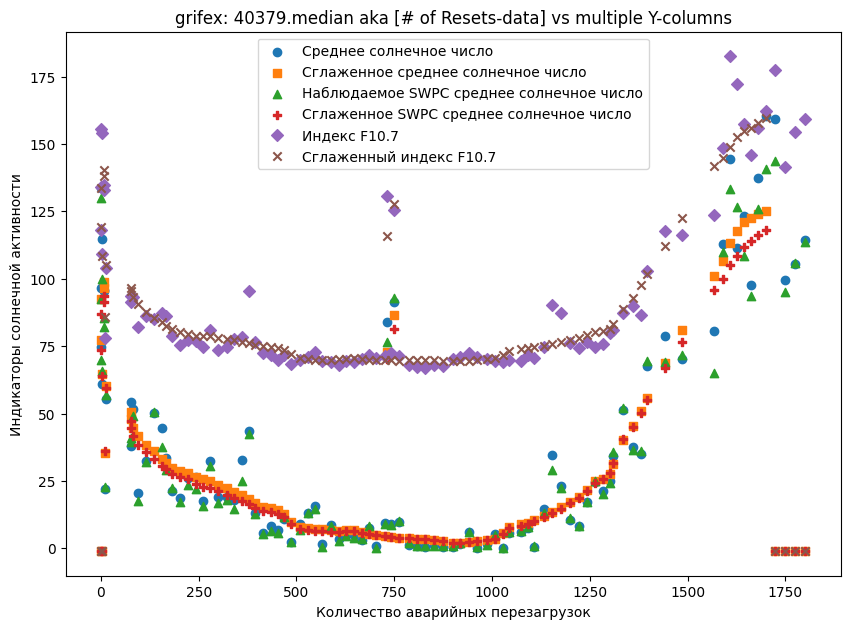

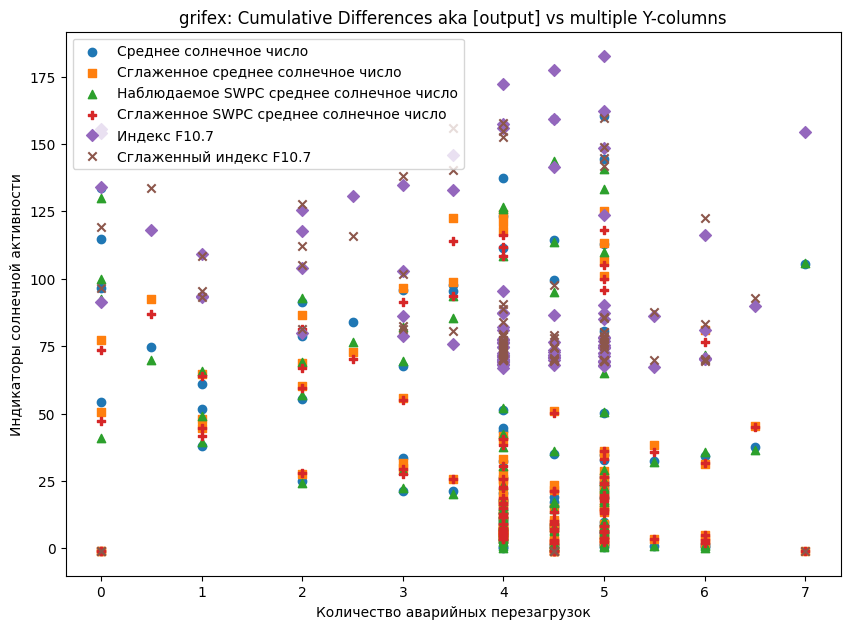

In [24]:
analyze_satellite('grifex')